# Proper normalization

In [2]:
using DataFrames
using Flux
import JSON
using LinearAlgebra
using MLUtils
using Plots
using StatsBase
using StatsPlots

include("helpers.jl")

stratifyarchitecturedimension (generic function with 2 methods)

## Edit before running on new data

In [3]:
x_columns_to_drop = []
y_columns_to_drop = []
target_directory = "data/full_opt_15KeV/"

"data/full_opt_15KeV/"

## Getting data together

In [4]:
# get data
x_raw_df = DataFrame(
    DVAR1=Float64[],
    DVAR2=Float64[],
    DVAR3=Float64[],
    DVAR4=Float64[],
    DVAR5=Float64[],
    DVAR6=Float64[],
    DVAR7=Float64[],
    DVAR8=Float64[],
    DVAR9=Float64[],
    DVAR10=Float64[],
    DVAR11=Float64[],
    DVAR12=Float64[],
    DVAR13=Float64[],
    DVAR14=Float64[]
)
y_raw_df = DataFrame(
    OBJ1=Float64[],
    OBJ2=Float64[],
    OBJ3=Float64[],
    OBJ4=Float64[],
    OBJ5=Float64[],
    OBJ6=Float64[]
)

x_raw_df, y_raw_df = readjsonsfromdirectory(target_directory, x_raw_df, y_raw_df);

## EDA

In [204]:
# some cuts
abnormally_high_rfq_length = 220. # OBJ3
abnormally_high_longitudinal_emittance = 0.2 # OBJ4
abnormally_high_x_emittance = 0.08 # OBJ5
abnormally_high_y_emittance = 0.08 # OBJ6

non_outlier_conditional = (y_raw_df[:, "OBJ3"] .<= abnormally_high_rfq_length) .&
    (y_raw_df[:, "OBJ4"] .<= abnormally_high_longitudinal_emittance) .&
    (y_raw_df[:, "OBJ5"] .<= abnormally_high_x_emittance) .&
    (y_raw_df[:, "OBJ6"] .<= abnormally_high_y_emittance)

# process data
x_outliers_df = x_raw_df[(!).(non_outlier_conditional), :];
y_outliers_df = y_raw_df[(!).(non_outlier_conditional), :];

x_df = x_raw_df[non_outlier_conditional, :];
y_df = y_raw_df[non_outlier_conditional, :];

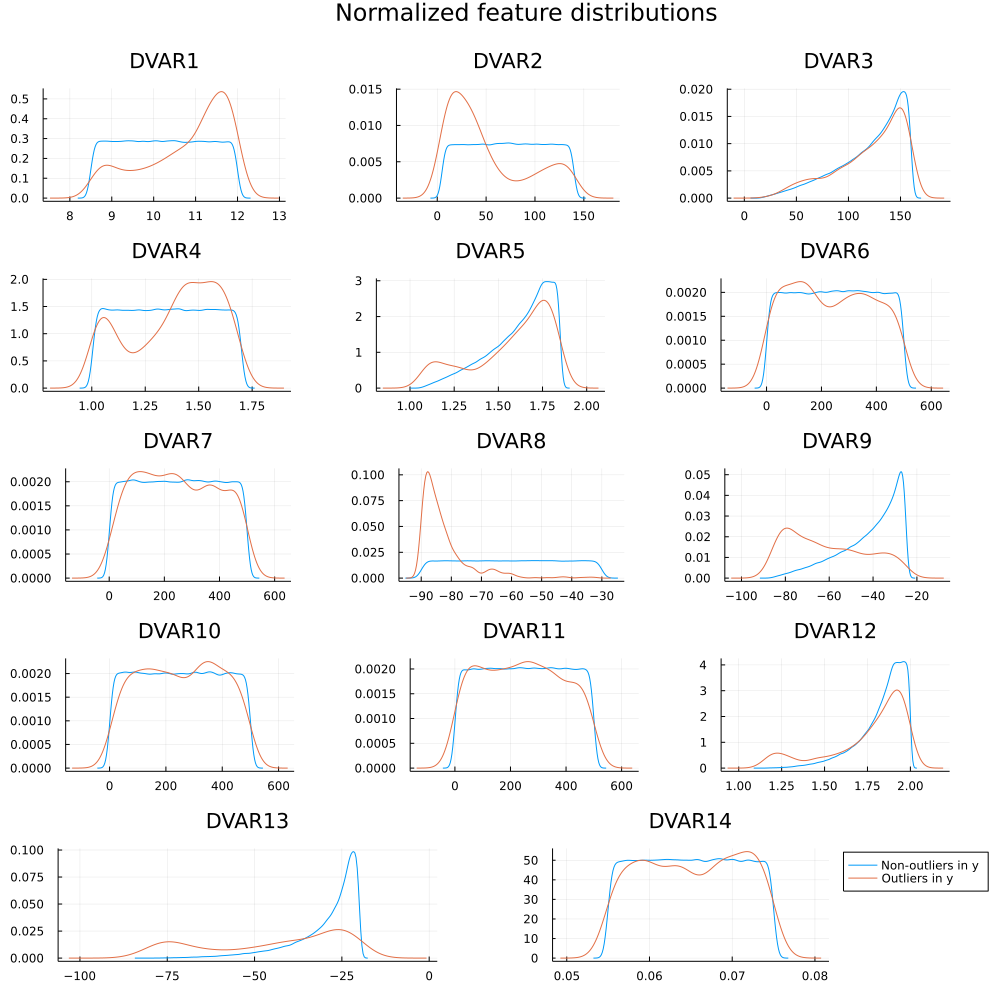

In [238]:
# features split by outlier
l = @layout [a b c; d e f; g h i; j k l; m n]

subplots = []
for i in 1:14
    sp = density(x_df[:, "DVAR$i"]; label=(i == 14 ? "Non-outliers in y" : ""), legend=(i==14), title="DVAR$i")
    density!(sp, x_outliers_df[:, "DVAR$i"]; label=(i == 14 ? "Outliers in y" : ""), legend=:outertopright)
    push!(subplots, sp)
end

plot(subplots..., layout=l, size=(1000, 1000), plot_title="Normalized feature distributions")

## Data preprocessing

In [125]:
# scaler
mutable struct MinMaxScaler
    data_min::Float64
    data_max::Float64
end

function fit!(scaler, data)
    scaler.data_min = minimum(data); scaler.data_max = maximum(data)
end

function transform(scaler, data)
    [2*(d - scaler.data_min)/(scaler.data_max - scaler.data_min) - 1 for d in data]
end

function inverse_transform(scaler, data_scaled)
    [0.5*(scaler.data_max - scaler.data_min)*(d_s + 1) + scaler.data_min for d_s in data_scaled]
end

function fit_transform(data)
    scaler = MinMaxScaler(0., 0.)
    fit!(scaler, data)
    transform(scaler, data)
end

# sanity checking
data_test = [1., 2., 3., 4., 5.]
scaler_test = MinMaxScaler(0., 0.)
fit!(scaler_test, data_test)
data_test_scaled = transform(scaler_test, data_test)
@assert(maximum(data_test_scaled) == 1.0)
@assert(minimum(data_test_scaled) == -1.0)
@assert(maximum(data_test) == maximum(inverse_transform(scaler_test, data_test_scaled)))
@assert(minimum(data_test) == minimum(inverse_transform(scaler_test, data_test_scaled)))

In [126]:
# drop any columns needed
select!(x_df, Not(x_columns_to_drop));
select!(y_df, Not(y_columns_to_drop));

In [127]:
# scaling data
x_scaled_df = hcat(DataFrame.(colname=>fit_transform(x_df[!, colname]) for colname in names(x_df))...)
y_scaled_df = hcat(DataFrame.(colname=>fit_transform(y_df[!, colname]) for colname in names(y_df))...)

@assert(all(maximum(x_scaled_df[!, colname]) == 1. for colname in names(x_scaled_df)))
@assert(all(minimum(x_scaled_df[!, colname]) == -1. for colname in names(x_scaled_df)))

In [128]:
# split into training and test sets
train_frac = 0.8
data_size = nrow(x_scaled_df)
train_size = trunc(Int, train_frac * data_size)

train_indexes = sample(1:data_size, train_size, replace=false)
test_indexes = (1:data_size)[(1:data_size) .∉ Ref(train_indexes)]

@assert(length(train_indexes) + length(test_indexes) == data_size)

x_train_df = x_scaled_df[train_indexes, :]; x_test_df = x_scaled_df[test_indexes, :];
y_train_df = y_scaled_df[train_indexes, :]; y_test_df = y_scaled_df[test_indexes, :];

In [129]:
# format to arrays
x_train = Matrix(x_train_df); x_test = Matrix(x_test_df);
y_train = Matrix(y_train_df); y_test = Matrix(y_test_df);

In [130]:
# get dimensions
x_dimension = size(x_train)[2];
y_dimension = size(y_train)[2];

## Building and training the neural net

In [355]:
# some other loss functions / metrics
max_valueormachinelimit(x) = max(x, eps())

# build the model
function neuralnetwork()
    Chain(
        Dense(x_dimension, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, y_dimension)
    )
end

neuralnetwork (generic function with 1 method)

In [356]:
# organizing data into batches
batch_size = 512
data_loader = Flux.Data.DataLoader((x_train', y_train'), batchsize=batch_size, shuffle=true);

In [357]:
# defining our model, optimization algorithm and loss function
m = neuralnetwork()
optimizer = ADAM()
loss(x, y) = Flux.mse(m(x), y)

# training
n_epochs = 2500
training_losses = Float64[]
epochs = Int64[]

for epoch in 1:n_epochs
    print("epoch $epoch,")
    Flux.train!(loss, Flux.params(m), data_loader, optimizer)
    push!(epochs, epoch)
    l = 0.
    for d in data_loader
        l += loss(d...)
    end
    println(" loss=$l")
    push!(training_losses, l)
end

epoch 1, loss=23.17564962927204
epoch 2, loss=9.801182649366003
epoch 3, loss=7.8239959736182705
epoch 4, loss=7.1607938836544
epoch 5, loss=6.561319310611043
epoch 6, loss=6.131838583501951
epoch 7, loss=5.864521736021881
epoch 8, loss=5.657142422722789
epoch 9, loss=5.5433535685972775
epoch 10, loss=5.394772237272977
epoch 11, loss=5.250055019344913
epoch 12, loss=5.126660052623155
epoch 13, loss=5.042799013777586
epoch 14, loss=4.949272391686058
epoch 15, loss=4.8533869578902795
epoch 16, loss=4.838097136927382
epoch 17, loss=4.761841240429407
epoch 18, loss=4.705272204289382
epoch 19, loss=4.622321943762385
epoch 20, loss=4.603212088308346
epoch 21, loss=4.5351127114079555
epoch 22, loss=4.436360248003437
epoch 23, loss=4.390383347101619
epoch 24, loss=4.338490949751785
epoch 25, loss=4.3150677935409645
epoch 26, loss=4.232259965333219
epoch 27, loss=4.187665637102547
epoch 28, loss=4.145106024640784
epoch 29, loss=4.168563988120234
epoch 30, loss=4.064820687227388
epoch 31, loss=4

epoch 479, loss=2.9959734535327103
epoch 480, loss=2.9969167368220826
epoch 481, loss=2.995209456486517
epoch 482, loss=2.988696150023479
epoch 483, loss=2.985015109872294
epoch 484, loss=2.9916409522148326
epoch 485, loss=2.983972980003985
epoch 486, loss=2.9811414124891704
epoch 487, loss=2.9937960452555537
epoch 488, loss=2.978703908142262
epoch 489, loss=2.99206850671969
epoch 490, loss=2.9926437661307723
epoch 491, loss=2.980695523042199
epoch 492, loss=2.993851349628238
epoch 493, loss=2.9819102874862704
epoch 494, loss=2.9827781088104794
epoch 495, loss=2.9898996900939734
epoch 496, loss=2.969586002970014
epoch 497, loss=2.9833876268798663
epoch 498, loss=2.97510468773731
epoch 499, loss=2.9704176409210343
epoch 500, loss=2.9958178932460715
epoch 501, loss=3.001246540647173
epoch 502, loss=2.971286946093303
epoch 503, loss=2.970358854110622
epoch 504, loss=2.9858953197343907
epoch 505, loss=2.9964523831187946
epoch 506, loss=2.9720504635346057
epoch 507, loss=2.993904807291619
e

epoch 717, loss=2.8969912400466202
epoch 718, loss=2.903267211795879
epoch 719, loss=2.893087977171496
epoch 720, loss=2.902978378152445
epoch 721, loss=2.90377802187157
epoch 722, loss=2.8995968756742023
epoch 723, loss=2.9133376560889572
epoch 724, loss=2.8928206546795563
epoch 725, loss=2.9039231625989865
epoch 726, loss=2.8928301315456926
epoch 727, loss=2.9025680594320193
epoch 728, loss=2.895486649750923
epoch 729, loss=2.9053003745503494
epoch 730, loss=2.897091504258397
epoch 731, loss=2.9052808463005184
epoch 732, loss=2.89990519902177
epoch 733, loss=2.9097097873816113
epoch 734, loss=2.902711778295106
epoch 735, loss=2.907606990296798
epoch 736, loss=2.893988455058528
epoch 737, loss=2.892387325600814
epoch 738, loss=2.9416427505827847
epoch 739, loss=2.893268407957197
epoch 740, loss=2.894123996407595
epoch 741, loss=2.8955072588989235
epoch 742, loss=2.8967745116957477
epoch 743, loss=2.9045747305168783
epoch 744, loss=2.9193847818417638
epoch 745, loss=2.9054360370986467


epoch 955, loss=2.8557629531393176
epoch 956, loss=2.842373935275599
epoch 957, loss=2.8407540432122125
epoch 958, loss=2.8389205202383927
epoch 959, loss=2.8414682288482855
epoch 960, loss=2.8452100501880784
epoch 961, loss=2.83809400882957
epoch 962, loss=2.844426554695995
epoch 963, loss=2.8428832761511424
epoch 964, loss=2.833005199172894
epoch 965, loss=2.8351463545266946
epoch 966, loss=2.8340521266268173
epoch 967, loss=2.8461008801788985
epoch 968, loss=2.830563453434359
epoch 969, loss=2.8388508890654123
epoch 970, loss=2.840511259446858
epoch 971, loss=2.8576122699826274
epoch 972, loss=2.8355773583174315
epoch 973, loss=2.8362994254109997
epoch 974, loss=2.8337645755309566
epoch 975, loss=2.83631090939081
epoch 976, loss=2.8338859644874517
epoch 977, loss=2.844364950567833
epoch 978, loss=2.834001093042789
epoch 979, loss=2.8337018932472495
epoch 980, loss=2.8353215505136995
epoch 981, loss=2.828283901253578
epoch 982, loss=2.8383977510496368
epoch 983, loss=2.83230556683604

epoch 1187, loss=2.8098739885992887
epoch 1188, loss=2.8169591168697905
epoch 1189, loss=2.7958107710537
epoch 1190, loss=2.8059315724291087
epoch 1191, loss=2.818803709231125
epoch 1192, loss=2.811576277634913
epoch 1193, loss=2.802089297590861
epoch 1194, loss=2.8084092148538455
epoch 1195, loss=2.8321227926614254
epoch 1196, loss=2.799583008476207
epoch 1197, loss=2.800213198885288
epoch 1198, loss=2.8086009791255084
epoch 1199, loss=2.7962330399610713
epoch 1200, loss=2.790849272940367
epoch 1201, loss=2.8006885837118305
epoch 1202, loss=2.8064608784523464
epoch 1203, loss=2.79248396335896
epoch 1204, loss=2.7909820168376767
epoch 1205, loss=2.796646127801129
epoch 1206, loss=2.79167735799171
epoch 1207, loss=2.8273988268405152
epoch 1208, loss=2.7965087094516807
epoch 1209, loss=2.791792973314462
epoch 1210, loss=2.820334902915174
epoch 1211, loss=2.8003649047347077
epoch 1212, loss=2.7965415289093607
epoch 1213, loss=2.8092187800655353
epoch 1214, loss=2.7937803566160695
epoch 12

epoch 1647, loss=2.7336310297836386
epoch 1648, loss=2.739487289823983
epoch 1649, loss=2.7436048596133116
epoch 1650, loss=2.733449288993004
epoch 1651, loss=2.7301669214164748
epoch 1652, loss=2.7469554378419816
epoch 1653, loss=2.7310827501345316
epoch 1654, loss=2.7453576221034712
epoch 1655, loss=2.730205909902269
epoch 1656, loss=2.748785019863932
epoch 1657, loss=2.738364532236591
epoch 1658, loss=2.724165557020233
epoch 1659, loss=2.7380873582580247
epoch 1660, loss=2.7221681938168363
epoch 1661, loss=2.730684827317497
epoch 1662, loss=2.7320914207367375
epoch 1663, loss=2.7377160322559315
epoch 1664, loss=2.724170999140689
epoch 1665, loss=2.73236762605642
epoch 1666, loss=2.720076526284866
epoch 1667, loss=2.732892032440266
epoch 1668, loss=2.7342979900259046
epoch 1669, loss=2.730893326042327
epoch 1670, loss=2.720400201129857
epoch 1671, loss=2.7297885904892403
epoch 1672, loss=2.731509864839335
epoch 1673, loss=2.731169153884326
epoch 1674, loss=2.7239595148722575
epoch 16

epoch 2109, loss=2.690859517282625
epoch 2110, loss=2.6751849940079504
epoch 2111, loss=2.6760291207858224
epoch 2112, loss=2.677302748605387
epoch 2113, loss=2.677433340575836
epoch 2114, loss=2.684713097527042
epoch 2115, loss=2.6762016737410534
epoch 2116, loss=2.680213609228801
epoch 2117, loss=2.6802420125293485
epoch 2118, loss=2.680926661510906
epoch 2119, loss=2.68378879420445
epoch 2120, loss=2.685474475198509
epoch 2121, loss=2.674613040969172
epoch 2122, loss=2.669790547078167
epoch 2123, loss=2.689519881303301
epoch 2124, loss=2.6771236665467546
epoch 2125, loss=2.6812588585698736
epoch 2126, loss=2.6865418534817134
epoch 2127, loss=2.6760076496882688
epoch 2128, loss=2.683575539659967
epoch 2129, loss=2.6730250283281256
epoch 2130, loss=2.668870896751637
epoch 2131, loss=2.6832413869529663
epoch 2132, loss=2.6758148824659744
epoch 2133, loss=2.6803195173896306
epoch 2134, loss=2.6768867460499606
epoch 2135, loss=2.6823063093567603
epoch 2136, loss=2.6709583650455855
epoch 

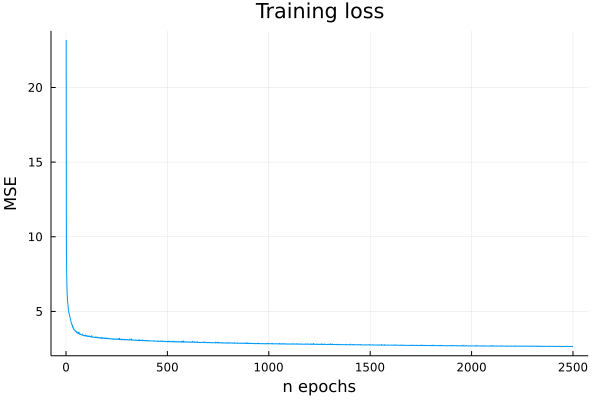

In [358]:
# plot the results
plot(epochs, training_losses; title="Training loss", xlabel="n epochs", ylabel="MSE", legend=false)

## Model evaluation

In [359]:
# rsquared
function r2score(yvec, ŷvec)
    ymean = mean(yvec)
    numerator = sum((y - ŷ)^2 for (y, ŷ) in zip(yvec, ŷvec))
    denominator = sum((y - ymean)^2 for y in yvec)
    1 - numerator / denominator
end
    
function r2score_multidim(ys, ŷs, multioutput::String="uniformaverage")
    d = size(ys, 2)
    r2score_rawvalues = [r2score(ys[:, i], ŷs[:, i]) for i in 1:d]
    if multioutput == "rawvalues"
        return r2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(r2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

r2score_multidim (generic function with 2 methods)

In [360]:
r2_train = r2score_multidim(y_train, m(x_train')')
r2_test = r2score_multidim(y_test, m(x_test')')
println("r2 on training set: $r2_train")
println("r2 on test set: $r2_test")

r2 on training set: 0.9345960579894556
r2 on test set: 0.9334747204677397


In [361]:
# adjusted rsquared
function adjustedr2score(yvec, ŷvec, p::Int)
    M = size(yvec, 1)
    return 1 - (1 - r2score(yvec, ŷvec)) * (M - 1) / (M - p - 1)
end

function adjustedr2score_multidim(ys, ŷs, p::Int, multioutput::String="uniformaverage")
    d = size(ys, 2)
    adjustedr2score_rawvalues = [adjustedr2score(ys[:, i], ŷs[:, i], p) for i in 1:d]
    if multioutput == "rawvalues"
        return adjustedr2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(adjustedr2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

adjustedr2score_multidim (generic function with 2 methods)

In [362]:
size(x_train, 2)

14

In [363]:
adjustedr2_train = adjustedr2score_multidim(y_train, m(x_train')', size(x_train, 2))
adjustedr2_test = adjustedr2score_multidim(y_test, m(x_test')', size(x_test, 2))
println("adjustedr2 on training set: $adjustedr2_train")
println("adjustedr2 on test set: $adjustedr2_test")

adjustedr2 on training set: 0.9345907726698899
adjustedr2 on test set: 0.9334532116362243


In [364]:
mae_train = Flux.mae(m(x_train')', y_train)
mae_test = Flux.mae(m(x_test')', y_test)
println("mae on training set: $mae_train")
println("mae on test set: $mae_test")

mae on training set: 0.05971049638796263
mae on test set: 0.05994952643394701


In [365]:
# mae for each response
y_train_preds = m(x_train')'
y_test_preds = m(x_test')'

for i in 1:y_dimension
    mae_train_by_dim = Flux.mae(y_train_preds[:,i], y_train[:, i])
    mae_test_by_dim = Flux.mae(y_test_preds[:, i], y_test[:, i])
    println("mae on training set for OBJ$i: $mae_train_by_dim")
    println("mae on test set for OBJ$i: $mae_test_by_dim")
end

mae on training set for OBJ1: 0.01934848510263447
mae on test set for OBJ1: 0.019818000094565854
mae on training set for OBJ2: 0.07463777877765773
mae on test set for OBJ2: 0.07473103357147594
mae on training set for OBJ3: 0.015062391767385098
mae on test set for OBJ3: 0.015068376048041452
mae on training set for OBJ4: 0.0313311718185163
mae on test set for OBJ4: 0.03141486083254585
mae on training set for OBJ5: 0.10925882987202958
mae on test set for OBJ5: 0.10957334400898484
mae on training set for OBJ6: 0.10862432098955259
mae on test set for OBJ6: 0.10909154404806819


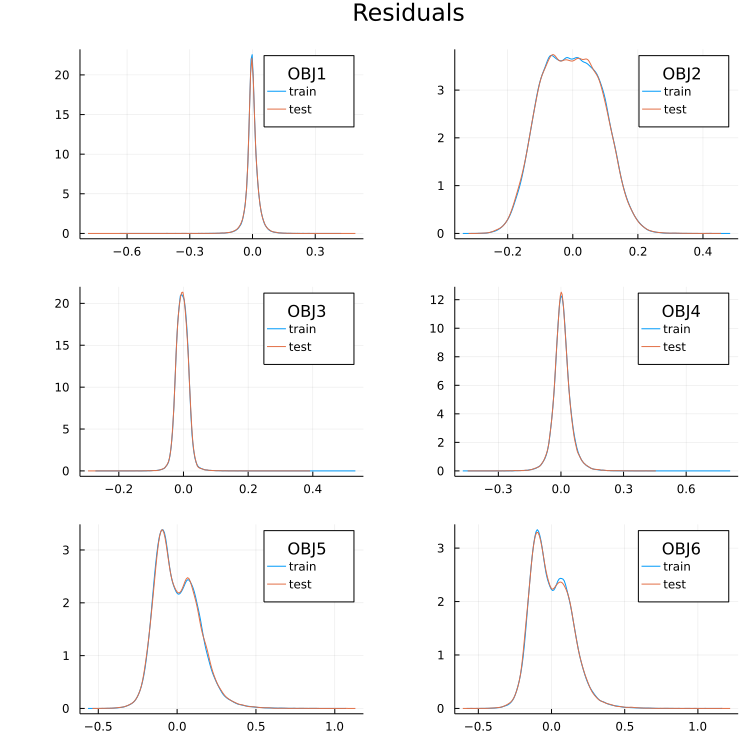

In [366]:
# plotting the residual distribution
l = @layout [grid(3,2)]

y_columns = names(y_df)
residuals_train = y_train - m(x_train')'
residuals_test = y_test - m(x_test')'

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = density(
        residuals_train[:, i];
        xlabel="", ylabel="", label="train", legend=true, legendtitle="    $colname", left_margin = 12Plots.mm
    )
    density!(sp, residuals_test[:, i]; xlabel="", ylabel="", label="test", legend=true)
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(750, 750), plot_title="Residuals")

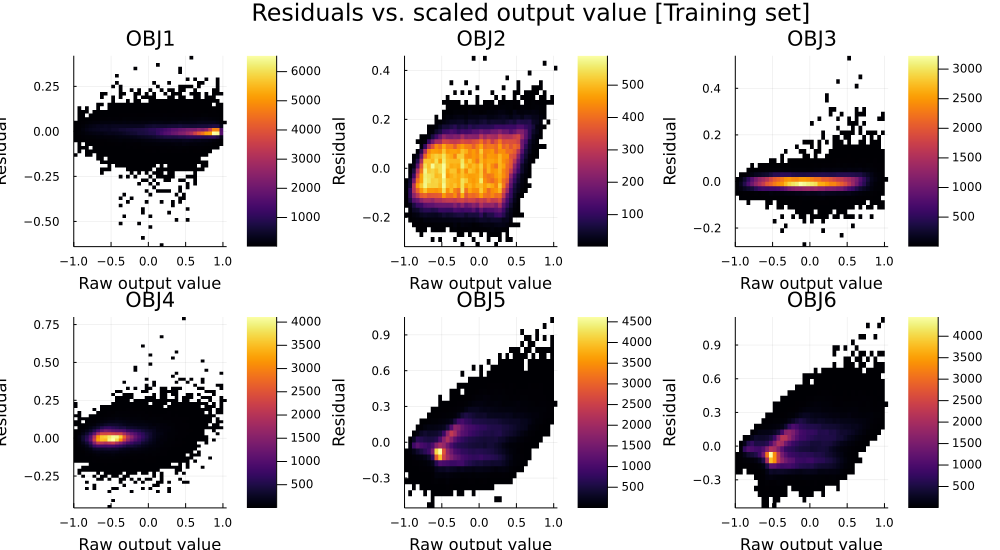

In [393]:
# residuals as a function of scaled objective value
l = @layout [grid(2,3)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = histogram2d(
        y_train[:, i], residuals_train[:, i];
        xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
        title="$colname", bins=(60, 60)
    )
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Training set]")

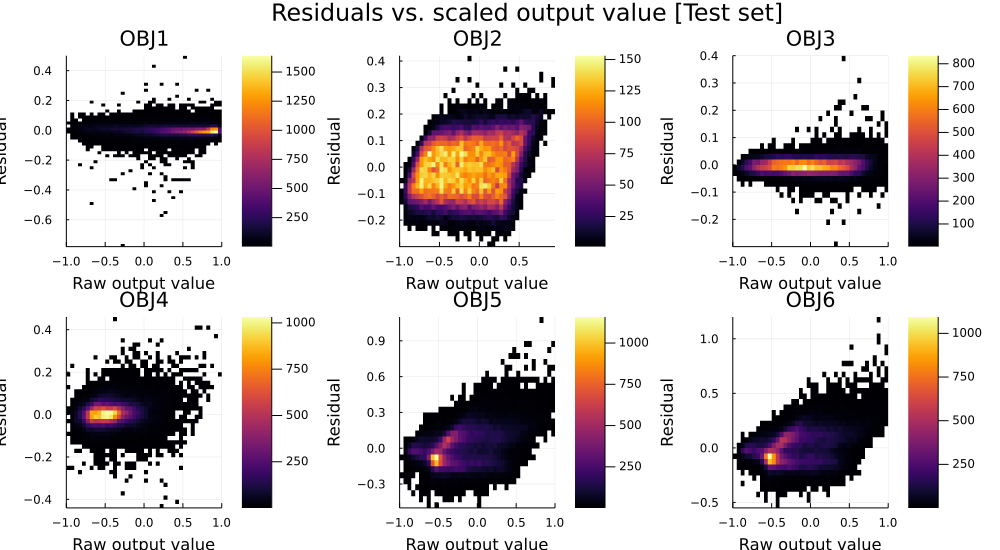

In [394]:
# residuals as a function of scaled objective value, test set
l = @layout [grid(2,3)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = histogram2d(
        y_test[:, i], residuals_test[:, i];
        xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
        title="$colname", bins=(60, 60)
    )
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Test set]")